"""
Copyright 2026 Zsolt Bedőházi

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
"""

In [ ]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
import ast
import shutil
from omegaconf import OmegaConf
import h5py

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import seaborn as sns
from sklearn.metrics import silhouette_score
import plotly.express as px

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# Load config
preproc_conf = OmegaConf.load("../conf/preproc.yaml")
preproc_conf = preproc_conf['classic_mil_on_embeddings_bag']['jmcs_224_224_patches']

## Get tables for NG

#### Load final_df_with_excluded_slides_cluster_tsne_1_2_3.csv, representing the new rev study cohort

In [3]:
final_df = pd.read_csv("cv_splits_multi_stratified_sklearn_s_a_r_mo_paper_patients_rev/final_df_with_excluded_slides_cluster_tsne_1_2_3.csv")
final_df["Pathological"] = final_df["Pathological"].astype(int)

In [4]:
np.array([len(ast.literal_eval(c)) for c in final_df['slide_id'].values]).sum()

9489

In [5]:
np.array([len(ast.literal_eval(c)) for c in final_df['biopsy_id'].values]).sum()

713

In [6]:
Counter(final_df.Pathological.values)

Counter({1: 478, 2: 70, 3: 26})

## Get tables for Semmelweis

In [7]:
biopsy_df_sote = pd.read_csv("private_external_test_set/biopsy_df.csv")
labels_df_sote = pd.read_csv("private_external_test_set/labels_df.csv")

In [8]:
biopsy_df_sote.shape, labels_df_sote.shape

((286, 17), (329, 18))

## Get tables for TCGA-BRCA

In [9]:
biopsy_df_tcga = pd.read_csv("tcga_brca_test_set//biopsy_df.csv")
labels_df_tcga = pd.read_csv("tcga_brca_test_set/labels_df.csv")

In [10]:
biopsy_df_tcga.shape, labels_df_tcga.shape

((678, 2), (731, 3))

## Embeddings

In [ ]:
# Nightingale (NG)
"<YOUR_PATH>/02_patch_embeddings/uni_finetuned_embs_1024_level4_macenko_improved_v2/"                      # slide level
"<YOUR_PATH>/02_patch_embeddings/uni_finetuned_biopsy_1024_level4_macenko_improved_v2_biopsies_rev"        # biopsy level  # this is not yet regrouped after tsne slide filer, but its not needed
"<YOUR_PATH>/02_patch_embeddings/uni_finetuned_biopsy_1024_level4_macenko_improved_v2_patients_excluded_slides_cluster_tsne_1_2_3_rev/"       # patient level

# Semmelweis
"<YOUR_PATH>/02_patch_embeddings/classic_mil/uni_finetuned_embs_1024_level_4_224_macenko_new_bracs/"          # slide level
"<YOUR_PATH>/04_embeddings_biopsy_bags/classic_mil/uni_finetuned_biopsy_1024_level_4_224_macenko_new_bracs/"  # patient level

# TCGA-BRCA
"<YOUR_PATH>/tcga-brca_breast_cancer_external_validation/patch_embeddings/uni_finetuned_embs_1024_level4_macenko/"       # slide level
"<YOUR_PATH>/tcga-brca_breast_cancer_external_validation/patch_embeddings/uni_finetuned_biopsy_1024_level4_macenko/"     # patient level


## PATIENT LEVEL

In [ ]:
# -------------------------
# PATHS TO PATIENT EMBEDDINGS
# -------------------------
ng_patient_dir = "<YOUR_PATH>/02_patch_embeddings/uni_finetuned_biopsy_1024_level4_macenko_improved_v2_patients_excluded_slides_cluster_tsne_1_2_3_rev/"
tcga_patient_dir = "<YOUR_PATH>/tcga-brca_breast_cancer_external_validation/patch_embeddings/uni_finetuned_biopsy_1024_level4_macenko/"
sem_patient_dir = "<YOUR_PATH>/04_embeddings_biopsy_bags/classic_mil/uni_finetuned_biopsy_1024_level_4_224_macenko_new_bracs/"

In [13]:
def load_patient_embedding(h5_path):
    with h5py.File(h5_path, "r") as f:
        features = f["features"][()]
        return np.mean(features, axis=0)  # Mean aggregation

In [14]:
def load_dataset_embeddings(dir_path, id_list, stage_dict, dataset_name):
    features, ids, labels, datasets = [], [], [], []

    for pid in tqdm(id_list):
        file_path = os.path.join(dir_path, f"{pid}.h5")
        if not os.path.exists(file_path):
            continue
        try:
            emb = load_patient_embedding(file_path)
            label = stage_dict.get(pid)
            if label is not None:
                features.append(emb)
                ids.append(pid)
                labels.append(label)
                datasets.append(dataset_name)
        except Exception as e:
            print(f"Error loading {file_path}: {e}")

    return pd.DataFrame(features), pd.DataFrame({
        "id": ids,
        "stage": labels,
        "dataset": datasets
    })

In [15]:
# NG
ng_stage_dict = dict(zip(final_df["patient_ngsci_id"], final_df["Pathological"]))
ng_ids = list(ng_stage_dict.keys())

# TCGA
tcga_stage_dict = dict(zip(biopsy_df_tcga["biopsy_id"], biopsy_df_tcga["stage"]))
tcga_ids = list(tcga_stage_dict.keys())

# Semmelweis
sem_stage_dict = dict(zip(biopsy_df_sote["base_slide_number"], biopsy_df_sote["clinical_stage"]))
sem_ids = list(sem_stage_dict.keys())


In [16]:
# Load NG
ng_X, ng_meta = load_dataset_embeddings(ng_patient_dir, ng_ids, ng_stage_dict, "NG")

# Load TCGA
tcga_X, tcga_meta = load_dataset_embeddings(tcga_patient_dir, tcga_ids, tcga_stage_dict, "TCGA")

# Load Semmelweis
sem_X, sem_meta = load_dataset_embeddings(sem_patient_dir, sem_ids, sem_stage_dict, "Semmelweis")

# Combine all
X = pd.concat([ng_X, tcga_X, sem_X], axis=0).values
meta_df = pd.concat([ng_meta, tcga_meta, sem_meta], axis=0).reset_index(drop=True)




00%|██████████| 286/286 [00:05<00:00, 47.67it/s]

In [17]:
X.shape

(1538, 1024)

In [18]:
meta_df.shape

(1538, 3)

In [19]:
def reduce_embeddings(X, method="pca"):
    X_scaled = StandardScaler().fit_transform(X)
    
    if method == "pca":
        model = PCA(n_components=2)
    elif method == "tsne":
        model = TSNE(n_components=2, perplexity=30, random_state=42)
    elif method == "umap":
        model = umap.UMAP(n_components=2, random_state=42)
    else:
        raise ValueError("Unknown method")
    
    return model.fit_transform(X_scaled)

In [20]:
def plot_2d(X_2d, meta_df, title, method, legend_loc="lower left", save_fig=False, save_path=None):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import os

    # Method label mapping
    method_labels = {
        "pca": "PCA",
        "tsne": "t-SNE",
        "umap": "UMAP"
    }
    method_label = method_labels.get(method.lower(), method.upper())

    # Legend position mapping
    legend_positions = {
        "lower left":  {"loc": "lower left",  "bbox": (0.02, 0.02)},
        "lower right": {"loc": "lower right", "bbox": (0.98, 0.02)},
        "upper left":  {"loc": "upper left",  "bbox": (0.02, 0.98)},
        "upper right": {"loc": "upper right", "bbox": (0.98, 0.98)},
    }
    legend_config = legend_positions.get(legend_loc.lower(), legend_positions["lower left"])

    # Prepare data
    plot_df = pd.DataFrame(X_2d, columns=["x", "y"])

    # Map stage and dataset names
    stage_map = {"1": "Stage I", "2": "Stage II", "3": "Stage III"}
    dataset_map = {"TCGA": "TCGA-BRCA"}

    plot_df["Stage"] = meta_df["stage"].astype(str).map(stage_map)
    plot_df["Dataset"] = meta_df["dataset"].replace(dataset_map)

    # Stage color palette
    stage_order = ["Stage I", "Stage II", "Stage III"]
    stage_palette = {
        "Stage I": "#6495ED",   # Blue
        "Stage II": "#FFA500",  # Orange
        "Stage III": "#FF0000"  # Red
    }

    plt.figure(figsize=(8, 6))
    sns.set(style="white")

    scatter = sns.scatterplot(
        data=plot_df,
        x="x", y="y",
        hue="Stage", hue_order=stage_order, palette=stage_palette,
        style="Dataset", s=70, alpha=0.6
    )

    # Axis labels
    plt.xlabel(f"{method_label} 1", fontsize=12)
    plt.ylabel(f"{method_label} 2", fontsize=12)

    # Title
    plt.title(title, fontsize=16, weight='bold')

    # Legend construction
    handles, labels = scatter.get_legend_handles_labels()
    
    #stage_handles = [h for h, l in zip(handles, labels) if l in stage_order]
    #dataset_labels = sorted(plot_df["Dataset"].unique())
    #dataset_handles = [h for h, l in zip(handles, labels) if l in dataset_labels]

    #combined_handles = stage_handles + dataset_handles
    #combined_labels = stage_order + dataset_labels

    # keep pairs so ordering can't desync
    stage_pairs = [(h, l) for h, l in zip(handles, labels) if l in stage_order]
    
    dataset_set = set(plot_df["Dataset"].unique())
    dataset_pairs = [(h, l) for h, l in zip(handles, labels) if l in dataset_set and l not in stage_order]
    
    combined_pairs = stage_pairs + dataset_pairs
    combined_handles = [h for h, l in combined_pairs]
    combined_labels  = [l for h, l in combined_pairs]    

    plt.legend(
        handles=combined_handles,
        labels=combined_labels,
        loc=legend_config["loc"],
        bbox_to_anchor=legend_config["bbox"],
        fontsize=12,
        ncol=2,
        borderaxespad=0.3,
        frameon=True
    )

    # Styling
    plt.grid(False)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

    # Save figure if requested
    if save_fig and save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(f"{save_path}.png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}.svg", bbox_inches="tight")

    plt.show()

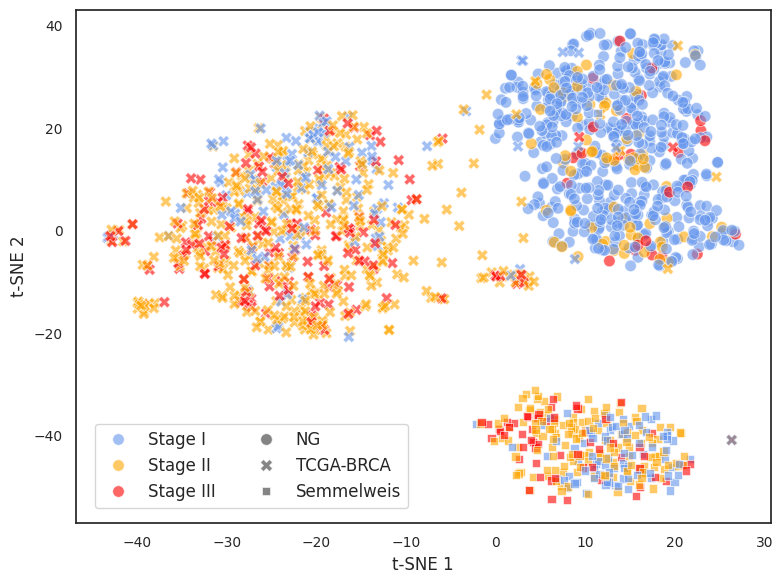

In [21]:
method="tsne"

X_red = reduce_embeddings(X, method=method)
plot_2d(X_red, meta_df, "", method, legend_loc="lower left", save_fig=True, save_path="figures/tsne_projection_patient_level_all_datasets")

In [22]:
def plot_2d_anonymized(X_2d, meta_df, title, method, legend_loc="lower left", save_fig=False, save_path=None):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    import os

    # Method label mapping
    method_labels = {
        "pca": "PCA",
        "tsne": "t-SNE",
        "umap": "UMAP"
    }
    method_label = method_labels.get(method.lower(), method.upper())

    # Legend position mapping
    legend_positions = {
        "lower left":  {"loc": "lower left",  "bbox": (0.02, 0.02)},
        "lower right": {"loc": "lower right", "bbox": (0.98, 0.02)},
        "upper left":  {"loc": "upper left",  "bbox": (0.02, 0.98)},
        "upper right": {"loc": "upper right", "bbox": (0.98, 0.98)},
    }
    legend_config = legend_positions.get(legend_loc.lower(), legend_positions["lower left"])

    # Prepare data
    plot_df = pd.DataFrame(X_2d, columns=["x", "y"])

    # Map stage and dataset names
    stage_map = {"1": "Stage I", "2": "Stage II", "3": "Stage III"}
    dataset_map = {"TCGA": "TCGA-BRCA"}

    # USED TO ANINYMIZE THE SEMMELWEIS COHORT
    dataset_map = {
    "TCGA": "TCGA-BRCA",
    "Semmelweis": "Internal cohort"
    }

    plot_df["Stage"] = meta_df["stage"].astype(str).map(stage_map)
    plot_df["Dataset"] = meta_df["dataset"].replace(dataset_map)

    # Stage color palette
    stage_order = ["Stage I", "Stage II", "Stage III"]
    stage_palette = {
        "Stage I": "#6495ED",   # Blue
        "Stage II": "#FFA500",  # Orange
        "Stage III": "#FF0000"  # Red
    }

    plt.figure(figsize=(8, 6))
    sns.set(style="white")

    scatter = sns.scatterplot(
        data=plot_df,
        x="x", y="y",
        hue="Stage", hue_order=stage_order, palette=stage_palette,
        style="Dataset", s=70, alpha=0.6
    )

    # Axis labels
    plt.xlabel(f"{method_label} 1", fontsize=12)
    plt.ylabel(f"{method_label} 2", fontsize=12)

    # Title
    plt.title(title, fontsize=16, weight='bold')

    # Legend construction
    handles, labels = scatter.get_legend_handles_labels()
    
    #stage_handles = [h for h, l in zip(handles, labels) if l in stage_order]
    #dataset_labels = sorted(plot_df["Dataset"].unique())
    #dataset_handles = [h for h, l in zip(handles, labels) if l in dataset_labels]

    #combined_handles = stage_handles + dataset_handles
    #combined_labels = stage_order + dataset_labels

    # keep pairs so ordering can't desync
    stage_pairs = [(h, l) for h, l in zip(handles, labels) if l in stage_order]
    
    dataset_set = set(plot_df["Dataset"].unique())
    dataset_pairs = [(h, l) for h, l in zip(handles, labels) if l in dataset_set and l not in stage_order]
    
    combined_pairs = stage_pairs + dataset_pairs
    combined_handles = [h for h, l in combined_pairs]
    combined_labels  = [l for h, l in combined_pairs]  

    plt.legend(
        handles=combined_handles,
        labels=combined_labels,
        loc=legend_config["loc"],
        bbox_to_anchor=legend_config["bbox"],
        fontsize=12,
        ncol=2,
        borderaxespad=0.3,
        frameon=True
    )

    # Styling
    plt.grid(False)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()

    # Save figure if requested
    if save_fig and save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(f"{save_path}.png", dpi=300, bbox_inches="tight")
        plt.savefig(f"{save_path}.svg", bbox_inches="tight")

    plt.show()

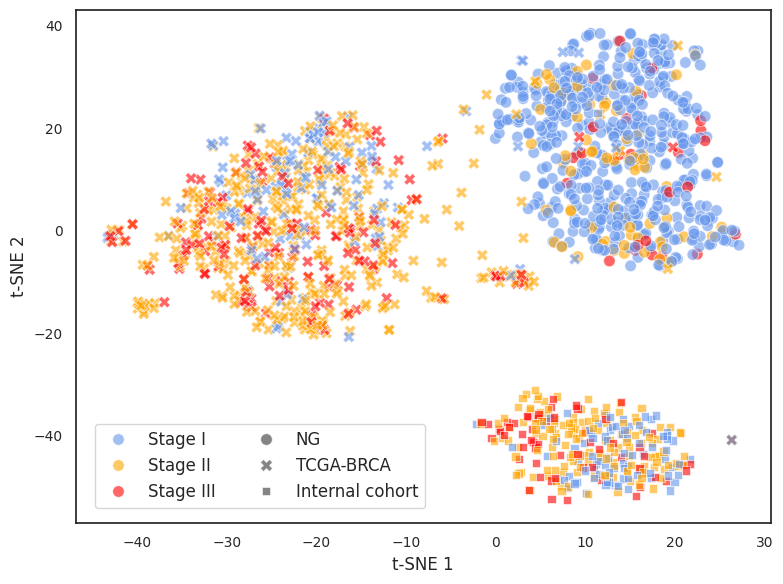

In [23]:
# SAVE THE SAME ANONIMYZED


method="tsne"

X_red = reduce_embeddings(X, method=method)
plot_2d_anonymized(X_red, meta_df, "", method, legend_loc="lower left", save_fig=True, save_path="figures/tsne_projection_patient_level_all_datasets_anonymized")